# Overview

In this notebook we will make three different models to predict the author for our spooky selections of text.  The first two models are similar and will use keras for a convolutional neural network with an embedded layer using GloVe.  The final model will be a little bit different... We'll get there when we get there.  The final model will be used for the submission to the contest.

## Intro

Before we start making our models, just out of curiosity, let's see what kind of words each author likes to use by displaying a wordcloud, and let's see if we can gain any insight from that.  Let's display a wordcloud for the entire training set, and then a wordcloud for each author.


Wordcloud for entire training set:


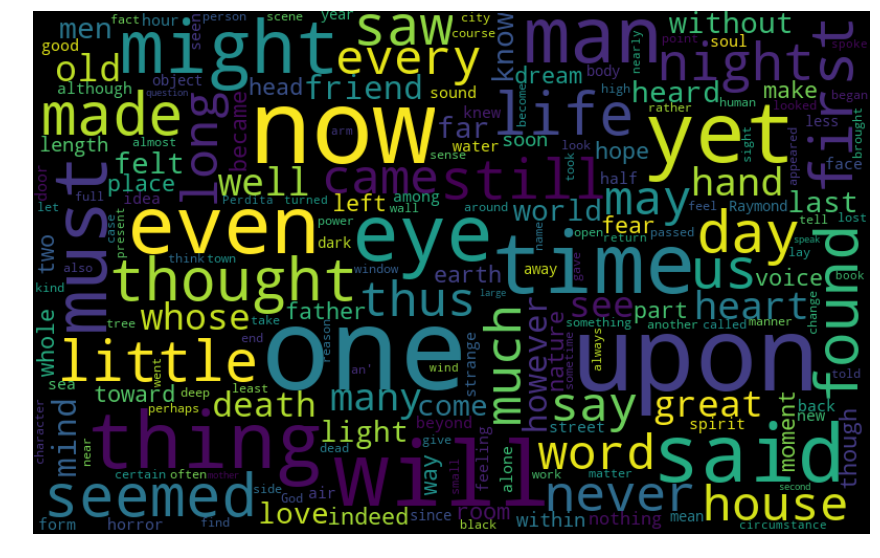

In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load training and testing text
train = pd.read_csv('./data/train.csv', skiprows=1, names=['ID', 'Text', 'Author']).set_index('ID')

# Delete the word 'id' from the ID columns
train.index = [id[2:] for id in train.index]

# Combine all training text into one large string
all_text = ' '.join([text for text in train['Text']])

# Wordcloud for entire training set
print("\nWordcloud for entire training set:")
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_text)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


Wordcloud for Edgar Allen Poe:


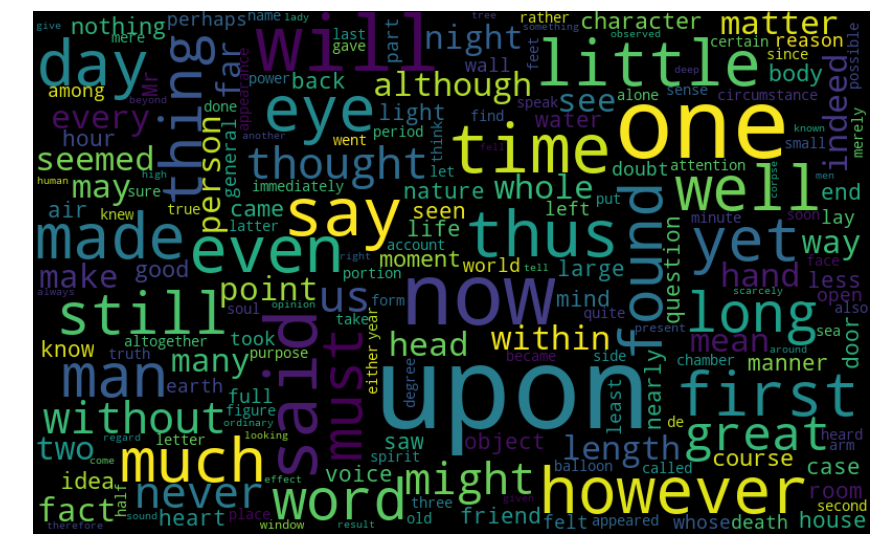

In [2]:
# Wordcloud for Edgar Allen Poe
eap = train[train['Author'] == 'EAP']
eap_text = ' '.join(text for text in eap['Text'])

print("\nWordcloud for Edgar Allen Poe:")
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(eap_text)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


Wordcloud for Mary Wollstonecraft Shelley:


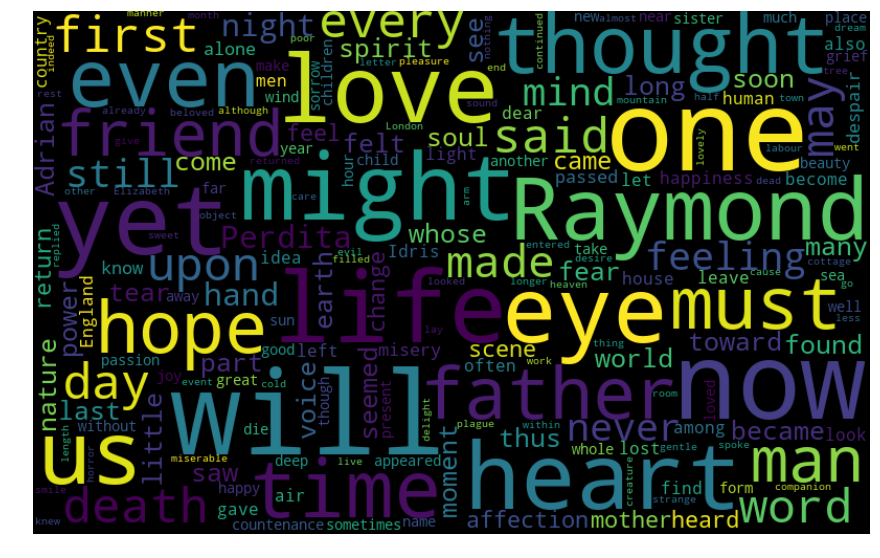

In [3]:
# Wordcloud for Mary Wollstonecraft Shelley
mws = train[train['Author'] == 'MWS']
mws_text = ' '.join(text for text in mws['Text'])

print("\nWordcloud for Mary Wollstonecraft Shelley:")
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(mws_text)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


Wordcloud for H.P. Lovecraft:


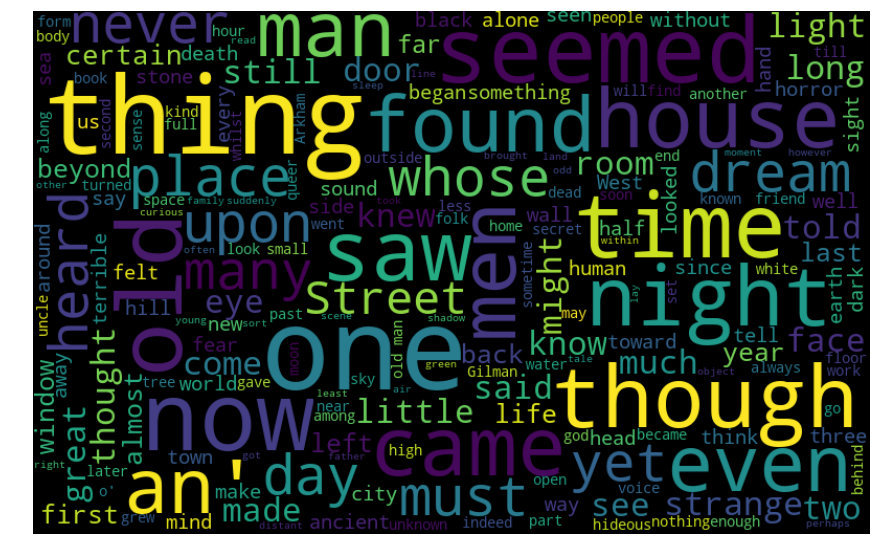

In [4]:
# Wordcloud for H.P. Lovecraft
hpl = train[train['Author'] == 'HPL']
hpl_text = ' '.join(text for text in hpl['Text'])

print("\nWordcloud for H.P. Lovecraft:")
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(hpl_text)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Okay, now we have an idea of some of the words that are popular for these authors.  Nothing seems out of the ordinary that we can take advantage of.  However, note that Mary frequently uses the word "Raymond", which is interesting, and it looks like H.P. Lovecraft likes "an'", whatever that is... (we will pursure punctuation as a feature in our third model - hang tight!).  Let's go ahead and start making some predictive models.

In [5]:
# Definitions needed for the first and second models.

import numpy as np
import keras
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
VALIDATION_SPLIT = 0.2 # Since the test.csv does not give us the corresponding labels, we must split the existing
                       # training data into our own test set if we want to see what our accuracy is.

Using TensorFlow backend.


## 1st Model - A Keras Convolutional Network

In the first model we will be using keras to implement a neural network with an embedded layer, and a single convolutional layer.  This first model is going to serve as a very basic example, to basically see what accuracy can be achieved without doing anything too fancy, this way we can compare our 2nd and 3rd models to it.

This model:

- Does not remove stopwords from the training data.
- Uses a network with:
 - A single embedded layer, using glove.6B.50d for the weights.
 - A single convolutional layer.
 - A single dense layer of 128 nodes.
 - A softmax output layer.


- Has an analysis section at the end, including model accuracy.
- The model accuracy and loss will be plotted over epochs in the analysis.

In [6]:
EMBEDDING_DIM = 50 # We will be using glove.6B.50d for our embedded weights for the 1st model.

# Let's read the training data into a dataframe.
df = pd.read_csv('./data/train.csv')
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [7]:
# Before we do anything else, let's simplify the authors
# by getting the exact number of classifications and generate
# a unique id for each class.

authors = dict([(auth, idx) for idx, auth in enumerate(df['author'].unique())])
print(authors)

# Put the numeric class back onto the data frame.
df['author_id'] = df['author'].apply(lambda x: authors[x])

df.head()

{'EAP': 0, 'MWS': 2, 'HPL': 1}


,id,text,author,author_id
0,id26305,"This process, however, afforded me no means of...",EAP,0
1,id17569,It never once occurred to me that the fumbling...,HPL,1
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,0
3,id27763,How lovely is spring As we looked from Windsor...,MWS,2
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,1


In [8]:
# Now we will use the text and author_id fields to train a classifier.

# Get the sentences and labels
sentences = df['text'].tolist()
labels = df['author_id'].tolist()

# Tokenize each sentence
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
print(len(sequences))
print(sequences[0])

# Get a vector of unique terms
word_index = tokenizer.word_index
print('\nFound %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels)) # using the custom id's we gave the authors as labels
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# with a validation set the size of 0.2 of the entire training set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

X_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
X_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

19579
[26, 2945, 143, 1372, 22, 36, 294, 2, 7451, 1, 2440, 2, 10, 4556, 16, 6, 79, 179, 48, 4245, 3, 295, 4, 1, 249, 1943, 6, 326, 74, 134, 123, 891, 2, 1, 313, 39, 1438, 4928, 98, 1, 430]

Found 25943 unique tokens.
Shape of data tensor: (19579, 1000)
Shape of label tensor: (19579, 3)


In [9]:
# At this point our data is prepared and all ready to go.
# Next we can start to prepare for the CNN model by loading
# in the embedding data from GloVe.

embeddings_index = {}
f = open('./data/glove.6B/glove.6B.50d.txt') # using 50d vectors
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [10]:
# Now create the embedding matrix for the training set
# to be used as the weights in the network.

num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [11]:
# For this model we will be using the embedded glove.6B.50d, and we will set
# the embedded layer to be untrainable so we do not change these weights.

# Let's create our network:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Network with 1 embedded layer, 1 conv1D layer, 1 GlobalMaxPooling layer, 1 dense layer.
# Again, this is meant to be a basic model to set a standard for comparison with better models.

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(len(authors), activation='softmax')(x)

model = Model(sequence_input, outputs)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [12]:
estimator = model.fit(X_train, y_train,
                      batch_size=128,
                      epochs=20, # ~6 minutes per epoch running on a virtual machine
                      validation_data=(X_val, y_val))

Train on 15664 samples, validate on 3915 samples
Epoch 1/20
15664/15664 [==============================] - 397s 25ms/step - loss: 0.9381 - acc: 0.5514 - val_loss: 0.8725 - val_acc: 0.6023
Epoch 2/20
15664/15664 [==============================] - 396s 25ms/step - loss: 0.7964 - acc: 0.6470 - val_loss: 0.7975 - val_acc: 0.6447
Epoch 3/20
15664/15664 [==============================] - 395s 25ms/step - loss: 0.7182 - acc: 0.6866 - val_loss: 0.8357 - val_acc: 0.6238
Epoch 4/20
15664/15664 [==============================] - 394s 25ms/step - loss: 0.6604 - acc: 0.7173 - val_loss: 0.8538 - val_acc: 0.6227
Epoch 5/20
15664/15664 [==============================] - 394s 25ms/step - loss: 0.6037 - acc: 0.7439 - val_loss: 0.8394 - val_acc: 0.6358
Epoch 6/20
15664/15664 [==============================] - 394s 25ms/step - loss: 0.5572 - acc: 0.7713 - val_loss: 0.8271 - val_acc: 0.6350
Epoch 7/20
15664/15664 [==============================] - 394s 25ms/step - loss: 0.5128 - acc: 0.7896 - val_loss: 0.7

In [13]:
print("Training Accuracy: %.2f%%" % (100*estimator.history['acc'][-1]))
print("Validation Accuracy: %.2f%%" % (100*estimator.history['val_acc'][-1]))

model.summary()

Training Accuracy: 92.85%
Validation Accuracy: 66.18%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 50)          1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          32128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 1,049,027
Trainable params: 49,027
Non-trainable params: 1,000,000
_______

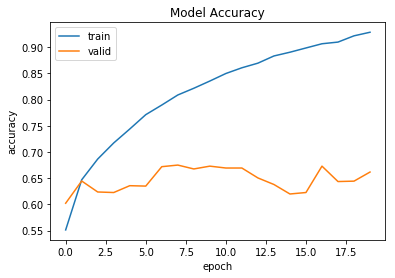

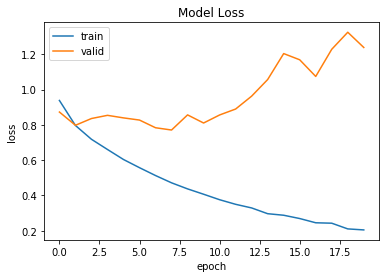

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot model accuracy over epochs
plt.plot(estimator.history['acc'])
plt.plot(estimator.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# Plot model loss over epochs
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## 2nd Model - A (Better) Keras Convolutional Network

In the first model we used keras to implement a neural network with an embedded layer, and a single convolutional layer.  For the second model we will be doing another keras network, but this time we will make some changes to the model.

This model:

- Uses lower case on the training sentences.
- Removes stopwords from the training data.
- Uses a network with:
 - A single embedded layer, using glove.6B.300d for the weights.
 - Three convolutional layers with maxpooling after each.
 - A global max pooling layer.
 - A single dense layer of 128 nodes.
 - A dropout layer with rate of .5
 - A softmax output layer.
 - Uses RMSprop optimizer with lr=0.005.


- Has an analysis section at the end, including model accuracy.
- The model accuracy and loss will be plotted over epochs in the analysis.

In [15]:
# Additional definitions for the 2nd Model

from keras.layers import Dropout
from keras.optimizers import RMSprop

EMBEDDING_DIM = 300    # We will be using glove.6B.300d for our embedded weights this time.

In [16]:
# We can use most of what has already been defined for the first model
# for our second model. The data has already been read into 
# the dataframe 'df'.  Let's do some extra processing to the 
# training set this time.

# Get the sentences and labels
sentences = df['text'].tolist()
labels = df['author_id'].tolist()

# Make all words lower case
sentences = df['text'].tolist()

print("Sample sentence before lower(): ", sentences[:1])

for i in range(len(sentences)):
    sentences[i] = sentences[i].lower()
    
print("\nSample sentence after lower(): ", sentences[:1])

Sample sentence before lower():  ['This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.']

Sample sentence after lower():  ['this process, however, afforded me no means of ascertaining the dimensions of my dungeon; as i might make its circuit, and return to the point whence i set out, without being aware of the fact; so perfectly uniform seemed the wall.']


In [17]:
# Tokenize the lower case sentences
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
print(len(sequences))
print(sequences[0])

# Get the stop words from nltk
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))

# Get a vector of unique terms
print('\nFound %s unique tokens before stopwords removal.' % len(tokenizer.word_index))
print([w for w in tokenizer.word_index.items()][:5])

# Now lets remove the stopwords from our data
word_index = dict([(w,i) for w,i in tokenizer.word_index.items() if w not in stops])
print('Found %s unique tokens after stopwords removal.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('\nShape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# with a validation set the size of 0.2 of the entire training set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

X_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
X_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

19579
[26, 2945, 143, 1372, 22, 36, 294, 2, 7451, 1, 2440, 2, 10, 4556, 16, 6, 79, 179, 48, 4245, 3, 295, 4, 1, 249, 1943, 6, 326, 74, 134, 123, 891, 2, 1, 313, 39, 1438, 4928, 98, 1, 430]

Found 25943 unique tokens before stopwords removal.
[('subjoined', 9065), ('saturday', 6467), ('satisfy', 2700), ('blockading', 24568), ('accomplished', 1710)]
Found 25808 unique tokens after stopwords removal.

Shape of data tensor: (19579, 1000)
Shape of label tensor: (19579, 3)


In [18]:
# At this point our data is prepared and all ready to go.
# Next we can start to prepare for the CNN model by loading
# in the embedding data from GloVe.

embeddings_index = {}
f = open('./data/glove.6B/glove.6B.300d.txt') # using 300 dimensional vectors
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [19]:
# Now we create the embedding matrix for the training set
# to be used as the weights in the network, just like we
# did before but this time using 300 dimensional vectors.

num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [20]:
# For the 2nd model we will use the glove.6b.300d as an embedded
# layer and this time we are going to set trainable to true
# and see if further training on the embedded weights will help.

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

# Network with 1 embedded layer, 3 conv1D layers, 1 GlobalMaxPooling layer, 1 dense layer, 1 dropout layer

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D()(x)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D()(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(.5)(x)
outputs = Dense(len(authors), activation='softmax')(x)
rms = RMSprop(lr=0.005) # change the default lr used in 1st model to 0.005

model = Model(sequence_input, outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=rms,
              metrics=['acc'])

In [21]:
estimator = model.fit(X_train, y_train,
                      batch_size=128,
                      epochs=20, # 26 minutes per epoch
                      validation_data=(X_val, y_val))

Train on 15664 samples, validate on 3915 samples
Epoch 1/20
15664/15664 [==============================] - 1184s 76ms/step - loss: 0.8454 - acc: 0.6500 - val_loss: 0.6116 - val_acc: 0.7425
Epoch 2/20
15664/15664 [==============================] - 1156s 74ms/step - loss: 0.4214 - acc: 0.8426 - val_loss: 0.7872 - val_acc: 0.7476
Epoch 3/20
15664/15664 [==============================] - 1157s 74ms/step - loss: 0.2303 - acc: 0.9179 - val_loss: 0.8030 - val_acc: 0.7992
Epoch 4/20
15664/15664 [==============================] - 1153s 74ms/step - loss: 0.1383 - acc: 0.9537 - val_loss: 0.9562 - val_acc: 0.7870
Epoch 5/20
15664/15664 [==============================] - 1156s 74ms/step - loss: 0.0823 - acc: 0.9744 - val_loss: 1.2934 - val_acc: 0.7867
Epoch 6/20
15664/15664 [==============================] - 1155s 74ms/step - loss: 0.0724 - acc: 0.9815 - val_loss: 1.2996 - val_acc: 0.7905
Epoch 7/20
15664/15664 [==============================] - 1155s 74ms/step - loss: 0.0580 - acc: 0.9846 - val_lo

In [22]:
print("Training Accuracy: %.2f%%" % (100*estimator.history['acc'][-1]))
print("Validation Accuracy: %.2f%%" % (100*estimator.history['val_acc'][-1]))

model.summary()

Training Accuracy: 99.19%
Validation Accuracy: 79.85%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 300)         6000000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 996, 128)          192128    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 498, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 494, 128)          82048     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)       

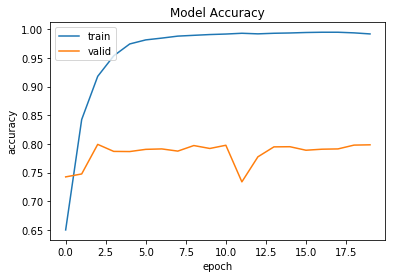

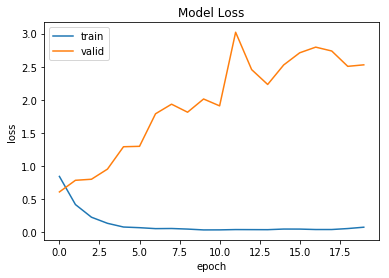

In [23]:
# Plot model accuracy over epochs
plt.plot(estimator.history['acc'])
plt.plot(estimator.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# Plot model loss over epochs
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## 3rd Model

In this final model we're going to do something a bit different.  We are going to implement the 'FastText' algorithm which is an algorithm that suggests little processing and uses a small convolutional network.  The network will consist of only 3 layers: an embedded layer, a global average pooling layer, and a dense layer.  We will also be using the adam optimizer for this model as well.

In [24]:
# Additional definitions needed for this model:

from collections import defaultdict

from keras.layers import GlobalAveragePooling1D
from keras.callbacks import EarlyStopping
from keras.models import Sequential

from sklearn.model_selection import train_test_split

np.random.seed(7)

In [25]:
df = pd.read_csv('./data/train.csv')
author_ids = {'EAP': 0, 'HPL' : 1, 'MWS' : 2}
y = np.array([author_ids[a] for a in df.author])
y = to_categorical(y)

For this model we are going to look at punctuation as a pre-processing feature.  Unlike the last model, here we will not be using lower case or removing stop words from the data set.  For this particular problem, I feel that whichever words are capitalized could be a feature.  An author may start sentences with a particular word more often than another author, thus that word would be capitalized more often for that particular author and that could be a feature.  I'm interested in what that might result in so let's try it.  This is kind of why we don't want to remove stopwords because 'The' would be removed, for example.  Also, let's see what kind of punctuation the authors use.

In [26]:
counter = {name : defaultdict(int) for name in set(df.author)}
for (text, author) in zip(df.text, df.author):
    text = text.replace(' ', '')
    for c in text:
        counter[author][c] += 1

chars = set()
for v in counter.values():
    chars |= v.keys()
    
names = [author for author in counter.keys()]

print('c ', end='')
for n in names:
    print(n, end='   ')
print()
for c in chars:    
    print(c, end=' ')
    for n in names:
        print(counter[n][c], end=' ')
    print()

c EAP   MWS   HPL   
ü 1 0 5 
x 1951 1267 1061 
W 739 681 732 
α 0 0 2 
ï 0 0 7 
" 2987 1469 513 
l 35371 27819 30273 
N 411 204 345 
Y 282 234 111 
Υ 0 0 1 
P 442 365 320 
f 22354 18351 16272 
C 395 308 439 
T 2217 1230 1583 
v 9624 7948 6529 
h 51580 43738 42770 
ç 1 0 0 
O 414 282 503 
Z 23 2 51 
H 864 669 741 
à 10 0 0 
p 17422 12361 10965 
a 68525 55274 56815 
c 24127 17911 18338 
b 13245 9611 10636 
ê 28 0 2 
V 156 57 67 
E 435 445 281 
Æ 1 0 4 
é 47 0 15 
ἶ 0 0 2 
Σ 0 0 1 
â 6 0 0 
u 26311 21025 19519 
n 62636 50291 50879 
K 86 35 176 
R 258 385 237 
D 491 227 334 
ë 0 0 12 
Ο 0 0 3 
I 4846 4917 3480 
k 4277 3707 5204 
: 176 339 47 
Π 0 0 1 
Q 21 7 10 
o 67145 53386 50996 
i 60952 46080 44250 
U 166 46 94 
î 1 0 0 
g 16088 12601 14951 
S 729 578 841 
ô 8 0 0 
ñ 0 0 7 
ä 1 0 6 
? 510 419 169 
æ 36 0 10 
' 1334 476 1710 
e 114885 97515 88259 
t 82426 63142 62235 
A 1258 943 1167 
, 17594 12045 8581 
q 1030 677 779 
G 313 246 318 
B 835 395 533 
s 53841 45962 43915 
m 22792 20471 1

In [27]:
# It looks like some of the authors use special characters, and sometimes 
# only one of the authors will use a particular character. We will use 
# special characters and punctuation as a preprocessing feature.
# Let's define a little function that we will apply to each sentence
# in the training set for preprocessing.

def preprocess(text):
    text = text.replace("' ", " ' ")
    signs = set(',.:;"?!')
    prods = set(text) & signs
    if not prods:
        return text

    for sign in prods:
        text = text.replace(sign, ' {} '.format(sign) )
    return text

In [28]:
def create_docs(df, n_gram_max=2):
    def add_ngram(q, n_gram_max):
            ngrams = []
            for n in range(2, n_gram_max+1):
                for w_index in range(len(q)-n+1):
                    ngrams.append('--'.join(q[w_index:w_index+n]))
            return q + ngrams
        
    docs = []
    for doc in df.text:
        doc = preprocess(doc).split()
        docs.append(' '.join(add_ngram(doc, n_gram_max)))
    
    return docs

In [29]:
# Another thing we will do is remove any words that occurred only
# 2 times or less for all authors and cut any sentences
# that are longer than 256 words.

min_count = 2

docs = create_docs(df)
tokenizer = Tokenizer(lower=False, filters='')
tokenizer.fit_on_texts(docs)
num_words = sum([1 for _, v in tokenizer.word_counts.items() if v >= min_count])

tokenizer = Tokenizer(num_words=num_words, lower=False, filters='')
tokenizer.fit_on_texts(docs)
docs = tokenizer.texts_to_sequences(docs)

maxlen = 256

docs = pad_sequences(sequences=docs, maxlen=maxlen)

In [30]:
# With our preprocessing strategy in place we can now take a look at
# creating our model.

X_train, X_test, y_train, y_test = train_test_split(docs, y, test_size=0.2)

input_dim = np.max(docs) + 1
embedding_dims = 20

# The network uses an embedded layer, a global average pooling layer, a dense layer,
# a softmax output layer, and for our optimizer we will be using adam this time.
# I tried using adam on the previous models but because the networks were much bigger
# than this one, adam would have never finished in time. (Taking 2 hours per epoch.)

model = Sequential()
model.add(Embedding(input_dim=input_dim, output_dim=embedding_dims))
model.add(GlobalAveragePooling1D())
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [31]:
estimator = model.fit(X_train, y_train,
                      batch_size=16,
                      validation_data=(X_test, y_test),
                      epochs=20,
                      callbacks=[EarlyStopping(patience=2, monitor='val_loss')])

Train on 15663 samples, validate on 3916 samples
Epoch 1/20
15663/15663 [==============================] - 30s 2ms/step - loss: 1.0675 - acc: 0.4077 - val_loss: 1.0298 - val_acc: 0.4545
Epoch 2/20
15663/15663 [==============================] - 25s 2ms/step - loss: 0.9330 - acc: 0.6121 - val_loss: 0.8592 - val_acc: 0.7163
Epoch 3/20
15663/15663 [==============================] - 25s 2ms/step - loss: 0.7251 - acc: 0.7874 - val_loss: 0.7072 - val_acc: 0.7574
Epoch 4/20
15663/15663 [==============================] - 25s 2ms/step - loss: 0.5657 - acc: 0.8475 - val_loss: 0.6096 - val_acc: 0.7870
Epoch 5/20
15663/15663 [==============================] - 25s 2ms/step - loss: 0.4523 - acc: 0.8801 - val_loss: 0.5402 - val_acc: 0.8041
Epoch 6/20
15663/15663 [==============================] - 25s 2ms/step - loss: 0.3663 - acc: 0.9068 - val_loss: 0.4877 - val_acc: 0.8195
Epoch 7/20
15663/15663 [==============================] - 25s 2ms/step - loss: 0.2987 - acc: 0.9283 - val_loss: 0.4506 - val_acc:

In [32]:
print("Training Accuracy: %.2f%%" % (100*estimator.history['acc'][-1]))
print("Validation Accuracy: %.2f%%" % (100*estimator.history['val_acc'][-1]))

model.summary()

Training Accuracy: 99.37%
Validation Accuracy: 86.67%
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 20)          1531940   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 63        
Total params: 1,532,003
Trainable params: 1,532,003
Non-trainable params: 0
_________________________________________________________________


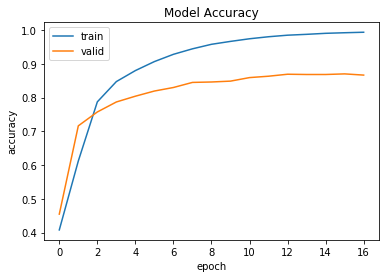

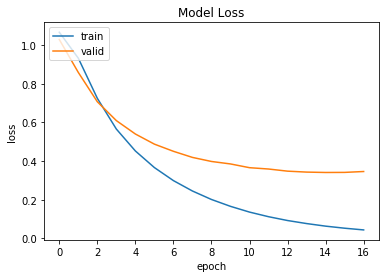

In [33]:
# Plot model accuracy over epochs
plt.plot(estimator.history['acc'])
plt.plot(estimator.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# Plot model loss over epochs
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

Alright, that puts an end to this journey of predicting authors from samples of spooky text.  To quickly summarize, the validation results for all three models are:

Validation Set Accuracy:
- Model 1: 66.18%
- Model 2: 79.85%
- Model 3: 86.67%

For submission to the contest we will use the 3rd model.

In [34]:
test_df = pd.read_csv('./data/test.csv')
docs = create_docs(test_df)
docs = tokenizer.texts_to_sequences(docs)
docs = pad_sequences(sequences=docs, maxlen=maxlen)
y = model.predict_proba(docs)

result = pd.read_csv('./data/sample_submission.csv')
for a, i in author_ids.items():
    result[a] = y[:, i]

In [35]:
result.to_csv('submission.csv', index=False)
result.head(10)

,id,EAP,HPL,MWS
0,id02310,0.006379,0.007683,9.859387e-01
1,id24541,0.999558,0.000442,2.454528e-07
2,id00134,0.001890,0.997748,3.622491e-04
3,id27757,0.932674,0.065038,2.287935e-03
4,id04081,0.288339,0.200082,5.115788e-01
5,id27337,0.998330,0.000935,7.351159e-04
6,id24265,0.966461,0.032585,9.536778e-04
7,id25917,0.000926,0.101539,8.975344e-01
8,id04951,0.999963,0.000035,1.266530e-06
9,id14549,0.918471,0.014236,6.729326e-02
